In [1]:
!nvidia-smi

Fri Jan 26 18:01:42 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P3    32W / 320W |    705MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from data_provider_6classes import *
from model import *
from pytorch_metric_learning import losses
import torch.optim as optim

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mimic_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/MIMIC-IV.csv.gz'
# mimic_df = pd.read_csv(mimic_data_dir, compression = 'gzip', usecols = ['subject_id','classes'])

In [4]:
## Build Dataset 
print(f'Build Dataset ....')

dataset_train = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
# loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, drop_last=True)

y_train_indices = dataset_train.df_num.index
y_train = [dataset_train.y[i] for i in y_train_indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
    
samples_weight = np.array([weight[t-1] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

loader_train = DataLoader(dataset_train, batch_size=128, shuffle=False, sampler=sampler, drop_last=True)


dataset_val = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=9040)
loader_val = DataLoader(dataset_val, batch_size=128, shuffle=False, drop_last=True)

dataset_vis = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=9040)
loader_vis = DataLoader(dataset_vis, batch_size=128, shuffle=False, drop_last=False)

# Tuple Containing the number of unique values within each category
card_categories = []
for col in dataset_train.df_cat.columns:
    card_categories.append(dataset_train.df_cat[col].nunique())

# dataset_test = TableDataset(data_path=args.mimic_data_dir, data_type='eicu',mode='test',seed=args.seed)
# loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

# # Tuple Containing the number of unique values within each category
# card_categories = []
# for col in dataset_test.df_cat.columns:
#     card_categories.append(dataset_test.df_cat[col].nunique())

Build Dataset ....
1082578
Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: classes
1    611446
2     14027
3     16190
4     10115
5     87586
6     17864
Name: count, dtype: int64
테스트셋 클래스 비율: classes
1    256166
2      6525
3      7038
4      4353
5     42806
6      8462
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.81:0.02:0.02:0.01:0.12:0.02
테스트셋 클래스 비율: 0.79:0.02:0.02:0.01:0.13:0.03
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 6916
테스트셋 환자 수: 2964
학습셋 체류 수: 7193
테스트셋 체류 수: 3096
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.7
임계값: 0.1
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.69
시도한 시행 횟수: 0
1082578
Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: classes
1    611446

In [5]:
# dataset_val_full = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=2582, sampling = False, case1 = False, case2 = False)
# loader_val_full = DataLoader(dataset_val_full, batch_size=128, shuffle=False, drop_last=False)

# dataset_val_full_case1 = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=2582, sampling = False, case1 = True, case2 = False)
# loader_val_full_case1 = DataLoader(dataset_val_full_case1, batch_size=128, shuffle=False, drop_last=False)

# dataset_val_full_case2 = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=2582, sampling = False, case1 = False, case2 = True)
# loader_val_full_case2 = DataLoader(dataset_val_full_case2, batch_size=128, shuffle=False, drop_last=False)

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 5723
seed_everything(seed = SEED)

In [7]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [11]:
import gc
gc.collect()
import optuna
from optuna.trial import TrialState

path_model = "./checkpoint"
if not os.path.exists(path_model):
    os.makedirs(os.path.join(path_model))

def param():
    categories = card_categories
    num_continuous = 156 
    dim = 78                       # Embedding Dimension of Input Data  32
    depth = 4                      # Nums of Attention Layer Depth  6
    heads = 2                      # Nums of Attention head
    dim_head = 78                 # Dimension of Attention(Q,K,V)
    attn_dropout = 0.4585             # Ratio of Attention Layer dropout
    ff_dropout = 0.56  # Ratio of FeedForward Layer dropout
    temp = 0.2598 
    total_epoch = 200
    lr =  1.646859237260144e-06
    num_special_tokens = 2
    return categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens

def train(trial, search = False):
    global emb_model, optimizer, train_loss_history  # train_loss_history 추가
    # device            = torch.device('cuda:0')
    train_loss_history = []  # Epoch별 평균 train loss 저장을 위한 리스트 초기화
    patience = 10
    early_stop_counter = 0
    Best_train_loss = float('inf')
    categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens = param()
    log_file = "training_log_transformer_optuna_pattern.txt" 
        
    def log_message(message):
        with open(log_file, "a") as file:
            file.write(message + "\n")
        print(message)
    
    
    # search parameters
    if search == True:
        lr = trial.suggest_uniform('lr', 0.000009, 0.0001)
        dim      = trial.suggest_int('dim', 60,100)
        dim_head = trial.suggest_int('dim', 2,8)
        depth      = trial.suggest_int('depth', 2,4)
        ff_dropout = trial.suggest_uniform('FeedForward Layer dropout', 0.3, 0.65)
        temp       = trial.suggest_uniform('temp', 0.05, 0.5)
        
    log_message(f'learning_rate : {lr}, \nepoch :  {total_epoch}, Embedding Dimension of Input Data : {dim}, Dimension of Attention : {dim_head}, Nums of Attention Layer Depth : {depth} drop_rate : {ff_dropout:.4f} temperature : {temp:.4f}')
    
    # 모델 정의
    emb_model = FTTransformer(categories=categories,
    num_continuous=num_continuous,
    dim=dim,
    depth=depth,
    heads=heads,
    dim_head=dim_head,
    num_special_tokens = 2,
    attn_dropout=attn_dropout,
    ff_dropout=ff_dropout).to(device)
    
    # print(emb_model)

    contrastive_loss = losses.SupConLoss(temperature=temp)
    # optimizer = optim.RMSprop(emb_model.parameters(), lr= lr)
    optimizer = optim.AdamW(emb_model.parameters(), lr = lr)
    # scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=15, T_mult=1, eta_max=0.01,  T_up=10, gamma=0.6)
    
    ## Model Train and Eval
    Best_valid_loss = 1e9
    for epoch in range(1, total_epoch+1):
        emb_model.train()
        running_loss = 0

        # current_lr = optimizer.param_groups[0]["lr"]
        
        for num_iter, batch_data in enumerate(tqdm(loader_train)):
            optimizer.zero_grad()
            
            X_num, X_cat, label = batch_data
            X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)

            latent, _ = emb_model(X_cat,X_num,True)
            label =  label.type(torch.LongTensor)
            
            # backward pass
            loss = contrastive_loss(latent, label)
            # loss = criterion(output, label.unsqueeze(dim = 1))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            # scheduler.step()  
            
        avg_train_loss = running_loss / len(loader_train)
        train_loss_history.append(avg_train_loss)  # 평균 train loss 저장
        log_message(f'Epoch {epoch}/{total_epoch} - Train Loss: {avg_train_loss:.4f}')
        
        with torch.no_grad():
            emb_model.eval()
            running_loss = 0
            mean_loss = 0
            for num_iter, batch_data in enumerate(tqdm(loader_val)):
                X_num, X_cat, label = batch_data
                X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)
                
                latent,_ = emb_model(X_cat,X_num,True)
                loss = contrastive_loss(latent, label)
                # loss = criterion(output, label.unsqueeze(dim = 1))
                
                running_loss += loss.item()
                
            # if num_iter % 5000 == 0:
                # log_message("VALID: EPOCH %04d / %04d | ITER %04d / %04d | LOSS %.4f" %
                #         (epoch, total_epoch, num_iter+1, len(loader_val), running_loss / (num_iter+1)))
        avg_valid_loss = np.round(running_loss / len(loader_val),4) 
        # log_message(f'Epoch{epoch} / {total_epoch} Valid Loss : {running_loss / len(loader_val)}')
        log_message(f'Epoch{epoch} / {total_epoch} Valid Loss : {avg_valid_loss}')


        if avg_valid_loss < Best_valid_loss:
            log_message(f'Best Loss {Best_valid_loss:.4f} -> {running_loss / len(loader_val):.4f} Update! & Save Checkpoint')
            Best_valid_loss = avg_valid_loss
            early_stop_counter = 0
            torch.save(emb_model.state_dict(),f'{path_model}/FTTransformer_pattern.pth')
            
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            log_message("Early stopping triggered due to valid loss")
            # trial.set_user_attr("early_stopped", True)
            # return TrialState.PRUNED
            return emb_model
        
    # return avg_valid_loss
    return emb_model

In [9]:
warnings.filterwarnings("ignore")
import os
import optuna

# # os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= '0'
# os.environ['CUDA_LAUNCH_BLOCKING']= '1'
# n_gpu             = 1
# device            = torch.device('cuda:0')

# # Set parameters

# study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize")
# study.optimize(train, n_trials = 4) 

# pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
# complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [13]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

model = train(trial=1, search = False)

learning_rate : 1.646859237260144e-06, 
epoch :  200, Embedding Dimension of Input Data : 78, Dimension of Attention : 78, Nums of Attention Layer Depth : 4 drop_rate : 0.5600 temperature : 0.2598


100%|██████████| 5915/5915 [05:12<00:00, 18.91it/s]


Epoch 1/200 - Train Loss: 4.8445


100%|██████████| 2541/2541 [00:59<00:00, 42.66it/s]


Epoch1 / 200 Valid Loss : 2.7985
Best Loss 1000000000.0000 -> 2.7985 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:09<00:00, 19.11it/s]


Epoch 2/200 - Train Loss: 4.7645


100%|██████████| 2541/2541 [00:59<00:00, 42.72it/s]


Epoch2 / 200 Valid Loss : 2.6906
Best Loss 2.7985 -> 2.6906 Update! & Save Checkpoint


100%|██████████| 5915/5915 [04:57<00:00, 19.87it/s]


Epoch 3/200 - Train Loss: 4.6608


100%|██████████| 2541/2541 [00:57<00:00, 44.11it/s]


Epoch3 / 200 Valid Loss : 2.6639
Best Loss 2.6906 -> 2.6639 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:16<00:00, 18.69it/s]


Epoch 4/200 - Train Loss: 4.6011


100%|██████████| 2541/2541 [01:00<00:00, 42.12it/s]


Epoch4 / 200 Valid Loss : 2.631
Best Loss 2.6639 -> 2.6310 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:28<00:00, 18.03it/s]


Epoch 5/200 - Train Loss: 4.5298


100%|██████████| 2541/2541 [01:00<00:00, 42.01it/s]


Epoch5 / 200 Valid Loss : 2.5927
Best Loss 2.6310 -> 2.5927 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:30<00:00, 17.88it/s]


Epoch 6/200 - Train Loss: 4.4496


100%|██████████| 2541/2541 [01:01<00:00, 41.14it/s]


Epoch6 / 200 Valid Loss : 2.5781
Best Loss 2.5927 -> 2.5781 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:28<00:00, 18.01it/s]


Epoch 7/200 - Train Loss: 4.3945


100%|██████████| 2541/2541 [01:01<00:00, 41.61it/s]


Epoch7 / 200 Valid Loss : 2.5669
Best Loss 2.5781 -> 2.5669 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:26<00:00, 18.10it/s]


Epoch 8/200 - Train Loss: 4.3533


100%|██████████| 2541/2541 [01:00<00:00, 41.86it/s]


Epoch8 / 200 Valid Loss : 2.5566
Best Loss 2.5669 -> 2.5566 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:08<00:00, 19.19it/s]


Epoch 9/200 - Train Loss: 4.3201


100%|██████████| 2541/2541 [00:57<00:00, 43.82it/s]


Epoch9 / 200 Valid Loss : 2.549
Best Loss 2.5566 -> 2.5490 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:14<00:00, 18.81it/s]


Epoch 10/200 - Train Loss: 4.2976


100%|██████████| 2541/2541 [00:59<00:00, 42.75it/s]


Epoch10 / 200 Valid Loss : 2.5431
Best Loss 2.5490 -> 2.5431 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:46<00:00, 17.08it/s]


Epoch 11/200 - Train Loss: 4.2778


100%|██████████| 2541/2541 [01:02<00:00, 40.88it/s]


Epoch11 / 200 Valid Loss : 2.5399
Best Loss 2.5431 -> 2.5399 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:19<00:00, 18.48it/s]


Epoch 12/200 - Train Loss: 4.2645


100%|██████████| 2541/2541 [00:58<00:00, 43.62it/s]


Epoch12 / 200 Valid Loss : 2.5375
Best Loss 2.5399 -> 2.5375 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:15<00:00, 18.75it/s]


Epoch 13/200 - Train Loss: 4.2507


100%|██████████| 2541/2541 [01:04<00:00, 39.69it/s]


Epoch13 / 200 Valid Loss : 2.5356
Best Loss 2.5375 -> 2.5356 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:18<00:00, 18.56it/s]


Epoch 14/200 - Train Loss: 4.2416


100%|██████████| 2541/2541 [01:01<00:00, 41.03it/s]


Epoch14 / 200 Valid Loss : 2.5342
Best Loss 2.5356 -> 2.5342 Update! & Save Checkpoint


100%|██████████| 5915/5915 [05:19<00:00, 18.50it/s]


Epoch 15/200 - Train Loss: 4.2332


100%|██████████| 2541/2541 [01:01<00:00, 41.30it/s]


Epoch15 / 200 Valid Loss : 2.533
Best Loss 2.5342 -> 2.5330 Update! & Save Checkpoint


 57%|█████▋    | 3357/5915 [02:59<02:15, 18.82it/s]

In [11]:
torch.save({"model_state_dict": emb_model.state_dict(),
            },
           f"Contrastive_Embedding_Net_ftt(0121-144epoch).pt")

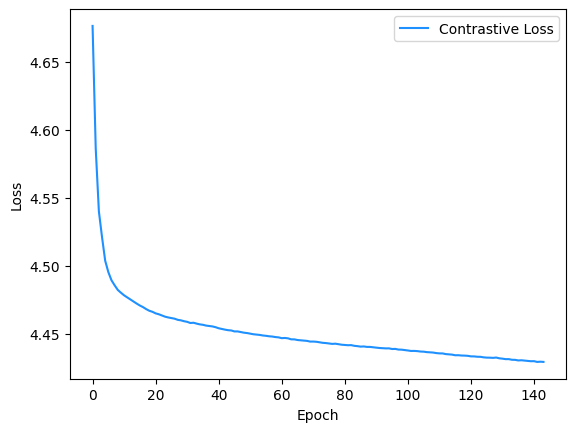

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(144),train_loss_history, color = 'dodgerblue', label = 'Contrastive Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# torch.save({"model_state_dict": model.state_dict(),
#             },
#            f"Contrastive_Embedding_Net_ftt(0116-300+210epoch).pt")

In [20]:
# torch.save({"model_state_dict": model.state_dict(),
#             },
#            f"Contrastive_Embedding_Net_ftt(0115).pt")

In [8]:
device            = torch.device('cuda:0')

In [9]:
# 모델 정의
model = FTTransformer(categories=card_categories,
num_continuous=153,
dim=32,
depth=2,
heads=2,
dim_head=32,
num_special_tokens = 2,
attn_dropout=0.56,
ff_dropout=0.65).to(device)

In [10]:
checkpoint = torch.load("Contrastive_Embedding_Net_ftt(0121-144epoch).pt")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [21]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import gc

gc.collect()

loader_val_out = DataLoader(dataset_val, batch_size=64, shuffle=False, drop_last=False)

import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import gc
import time

def make_embeded_df_valid(model_name, max_samples_per_class=5000):
    print('Start Getting the latent space vector (Valid sample)')
    start = time.time()

    model_name.eval()
    with torch.no_grad():
        emb_valid_list = []
        label_valid_list = []
        # 클래스별 attention 데이터를 저장할 딕셔너리
        att_valid_dict = {}

        for num_iter, batch_data in enumerate(tqdm(loader_val_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent, att_valid = model_name(X_cat, X_num, True)

            # Latent 데이터와 레이블 저장
            emb_valid_list.append(latent.cpu().numpy())
            label_valid_list.append(label.numpy())

            # 배치 내 각 샘플에 대해
            for i in range(label.size(0)):
                label_item = label[i].item()
                if att_valid_dict.get(label_item) is None:
                    att_valid_dict[label_item] = []

                if len(att_valid_dict[label_item]) < max_samples_per_class:
                    # 클래스별 attention 데이터 저장
                    # att_valid의 형태: (2, 배치크기, 2, 218, 218)
                    att_valid_dict[label_item].append(att_valid[:, i:i+1, :, :, :].cpu().numpy())

            gc.collect()

        # 리스트를 하나의 넘파이 배열로 변환
        emb_valid_array = np.concatenate(emb_valid_list, axis=0)
        label_valid_array = np.concatenate(label_valid_list, axis=0)

        # 클래스별 attention 데이터를 하나의 넘파이 배열로 변환
        att_valid_combined = {k: np.concatenate(v, axis=1) for k, v in att_valid_dict.items()}

    # DataFrame 생성
    emb_valid = pd.DataFrame(emb_valid_array)
    emb_valid_label = pd.DataFrame(label_valid_array)
    emb_valid_full = pd.concat([emb_valid, emb_valid_label], axis=1)
    end = time.time()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
    return emb_valid_full, att_valid_combined

# 모델 실행
emb_valid, valid_att = make_embeded_df_valid(model)


Start Getting the latent space vector (Valid sample)


100%|██████████| 4196/4196 [07:38<00:00,  9.16it/s]


End, Time consume (min): 7.698966161410014


In [16]:
next(iter(loader_vis))[0].shape

torch.Size([128, 153])

In [45]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import gc

gc.collect()

loader_val_out = DataLoader(dataset_val, batch_size=64, shuffle=False, drop_last=False)

dataset_vis_train = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=393, augmentation = False, visualization=True)
loader_vis_train = DataLoader(dataset_vis_train, batch_size=128, shuffle=False, drop_last=False)

import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import gc
import time

def make_embeded_df_valid(model_name):
    global att_valid_dict
    print('Start Getting the latent space vector (Valid sample)')
    start = time.time()

    model_name.eval()
    with torch.no_grad():
        emb_valid_list = []
        label_valid_list = []
        # 클래스별 attention 데이터를 저장할 딕셔너리
        att_valid_dict = []

        fixed_size = 128

        for num_iter, batch_data in enumerate(tqdm(loader_vis_train)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent, att_valid = model_name(X_cat, X_num, True)


            emb_valid_list.append(latent.cpu().numpy())
            label_valid_list.append(label.numpy())
            att_valid_dict.append(att_valid.detach().cpu().numpy())


            gc.collect()
        del_list = att_valid_dict.pop()

        emb_valid_array = np.concatenate(emb_valid_list, axis=0)
        label_valid_array = np.concatenate(label_valid_list, axis=0)
        att_valid_combined = np.concatenate(att_valid_dict, axis=1)

    # DataFrame 생성
    emb_valid = pd.DataFrame(emb_valid_array)
    emb_valid_label = pd.DataFrame(label_valid_array)
    emb_valid_full = pd.concat([emb_valid, emb_valid_label], axis=1)
    end = time.time()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
    return emb_valid_full, att_valid_combined

# 모델 실행
emb_valid, valid_att = make_embeded_df_valid(model)

========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: classes
0    28739
1     9988
2     2678
3    31905
Name: count, dtype: int64
테스트셋 클래스 비율: classes
0    13830
1     4518
2     1391
3    15896
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.39:0.14:0.04:0.44
테스트셋 클래스 비율: 0.39:0.13:0.04:0.45
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 811
테스트셋 환자 수: 348
학습셋 체류 수: 819
테스트셋 체류 수: 350
--------------------------------------
========== 실험 설정 ==========
분할 시드: 393
학습 비율: 0.7
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.08
시도한 시행 횟수: 0
Start Getting the latent space vector (Valid sample)


100%|██████████| 573/573 [01:18<00:00,  7.34it/s]


End, Time consume (min): 1.9707865079243978


In [46]:
valid_att.shape

(2, 73216, 2, 218, 218)

In [11]:
columns = ['CLS_Token'] + dataset_val.df_cat.columns.tolist() + dataset_val.df_num.columns.tolist()

In [15]:

# focus_columns는 시각화하고자 하는 특정 컬럼들의 인덱스 리스트
focus_col_name = ['HR', 'Temperature', 'MAP', 'ABPs', 'ABPd', 'Respiratory Rate', 'O2 Sat (%)', 'SVO2', 'SpO2',
'PaO2','FIO2 (%)', 'EtCO2', 'Cardiac Output', 'GCS_score', 'Lactate', 'Lactate_clearance_1h',
'Lactate_clearance_3h', 'Lactate_clearance_5h', 'Fluids(ml)', 'Glucose', 'cum_use_vaso','Alkaline_phosphatase','Anion gap',
'BUN','Total Bilirubin', 'ALT', 'Troponin-T', 'Creatinine','RedBloodCell', 'pH', 'Hemoglobin', 'Hematocrit'
'vasoactive/inotropic', 'Mechanical_circ_support', 'Age']  # 예시로 3, 5, 7번 컬럼에 집중

focus_columns = [columns.index(col) for col in focus_col_name if col in columns]


# 필요한 컬럼 이름만 추출
focus_columns_names = [columns[i] for i in focus_columns]



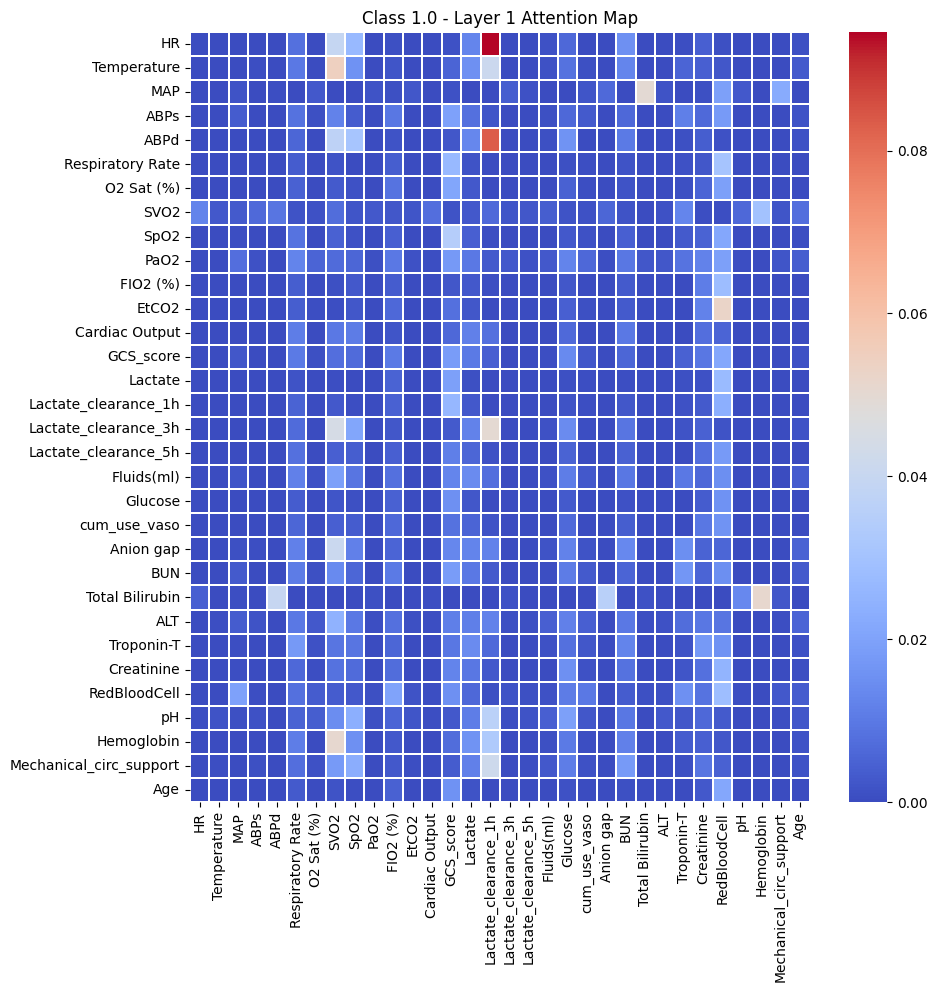

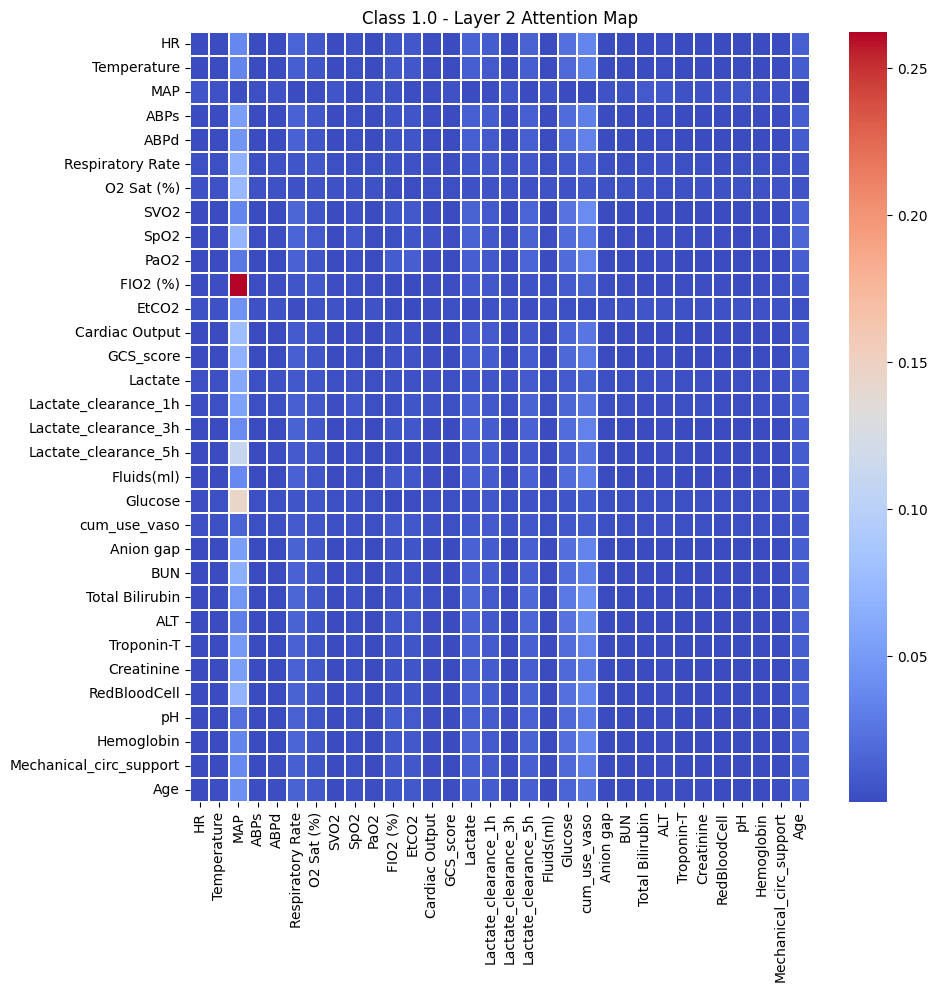

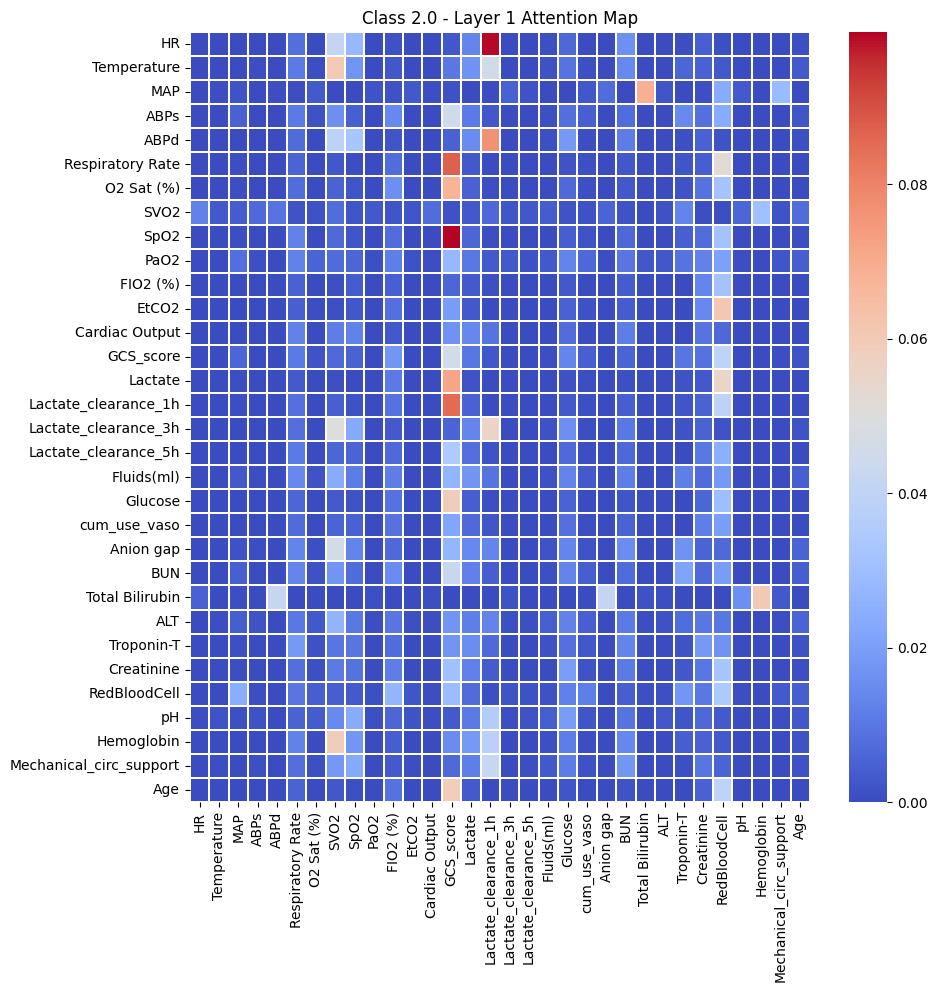

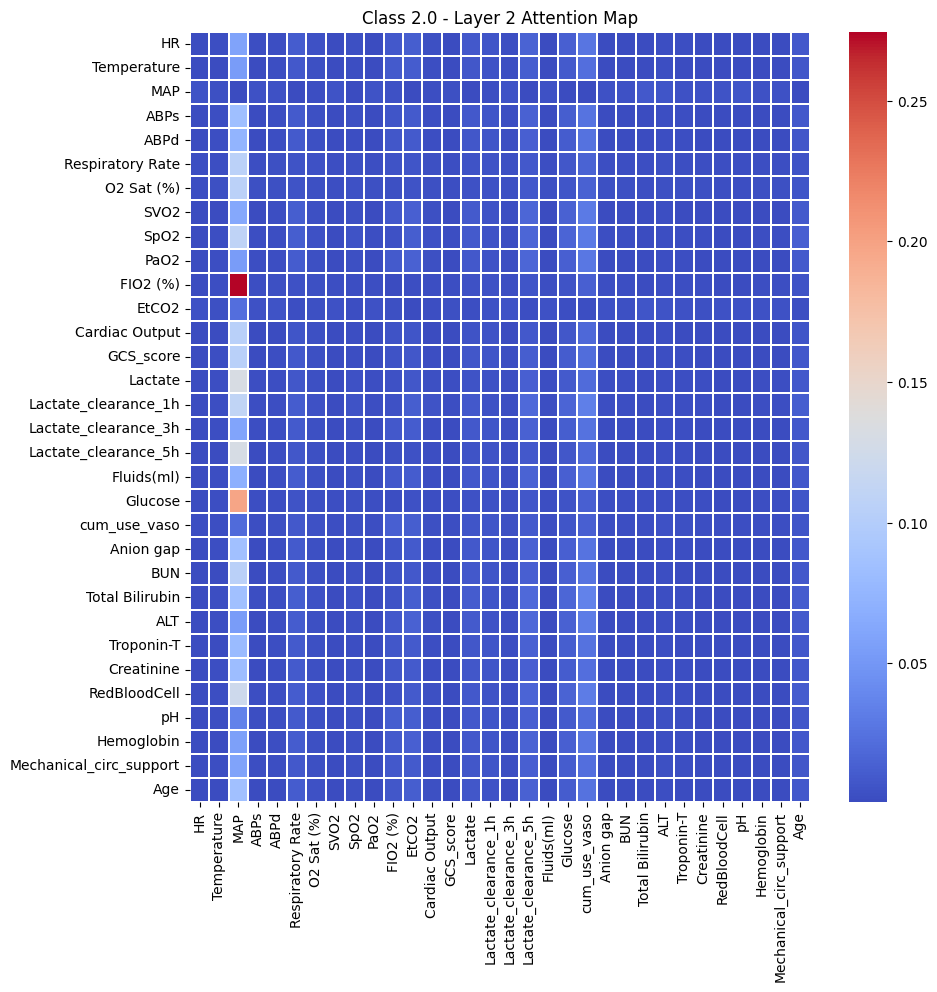

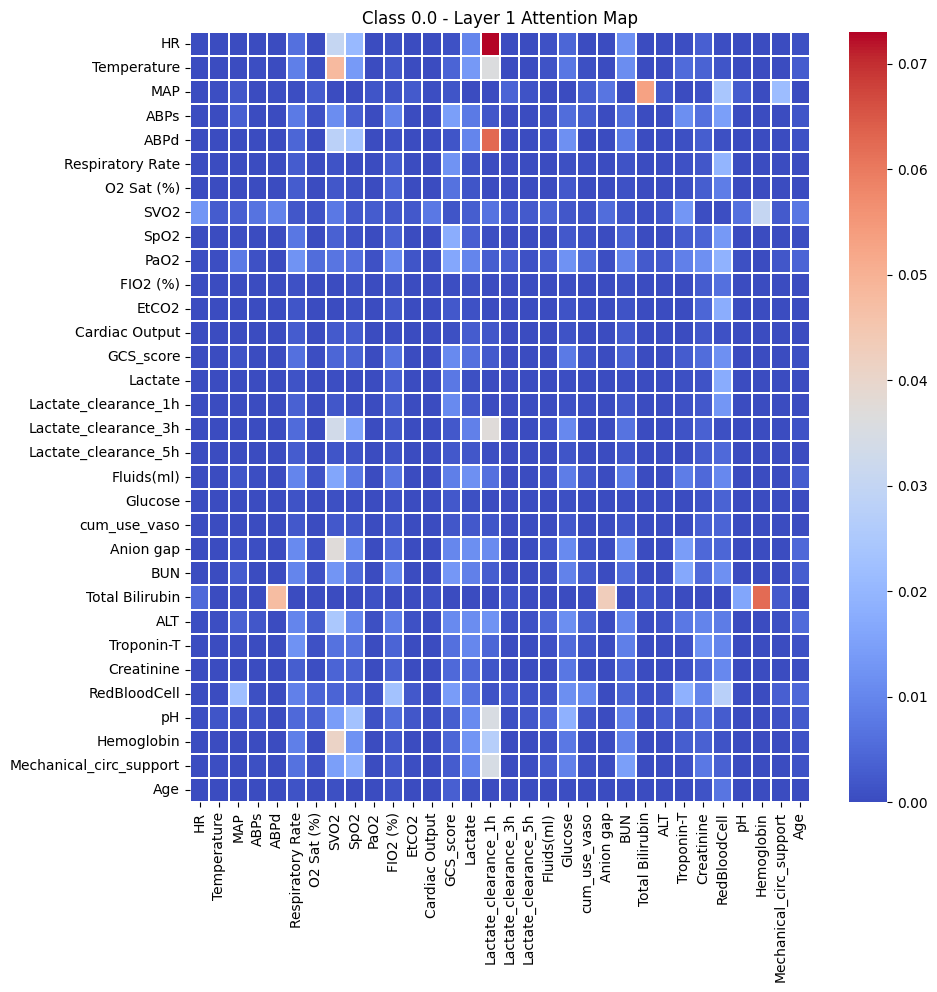

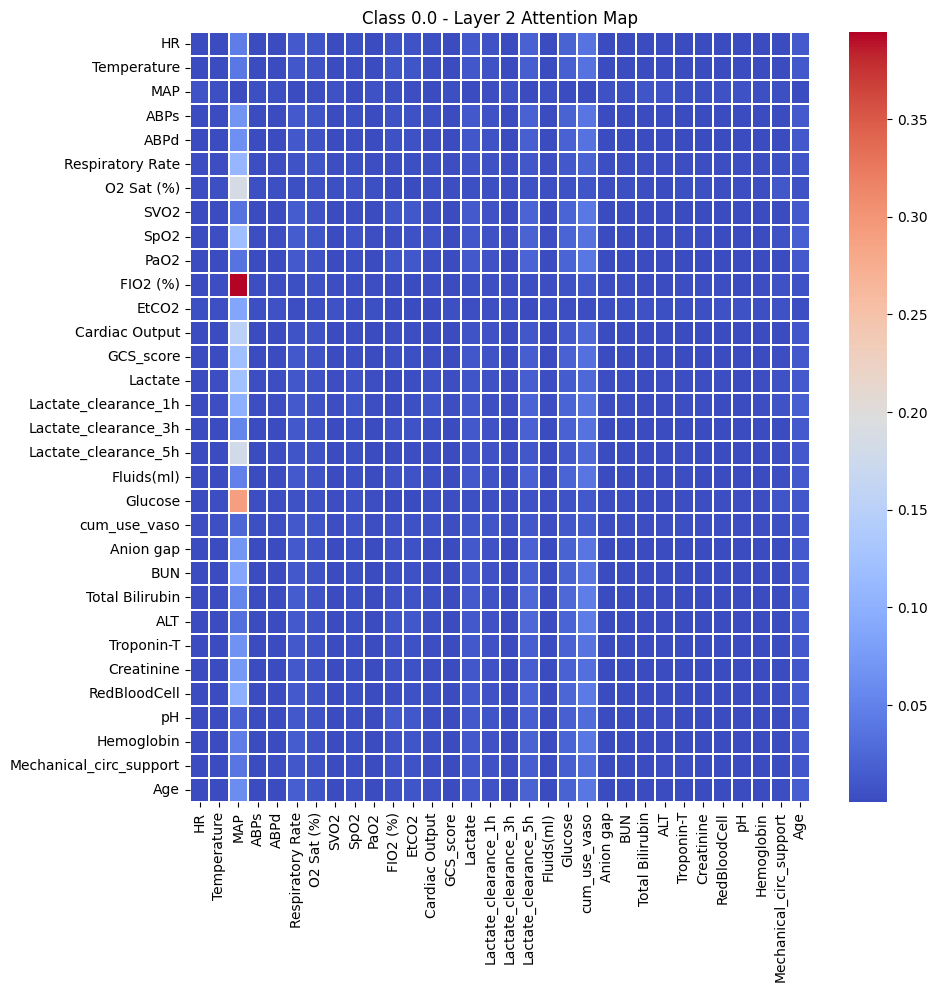

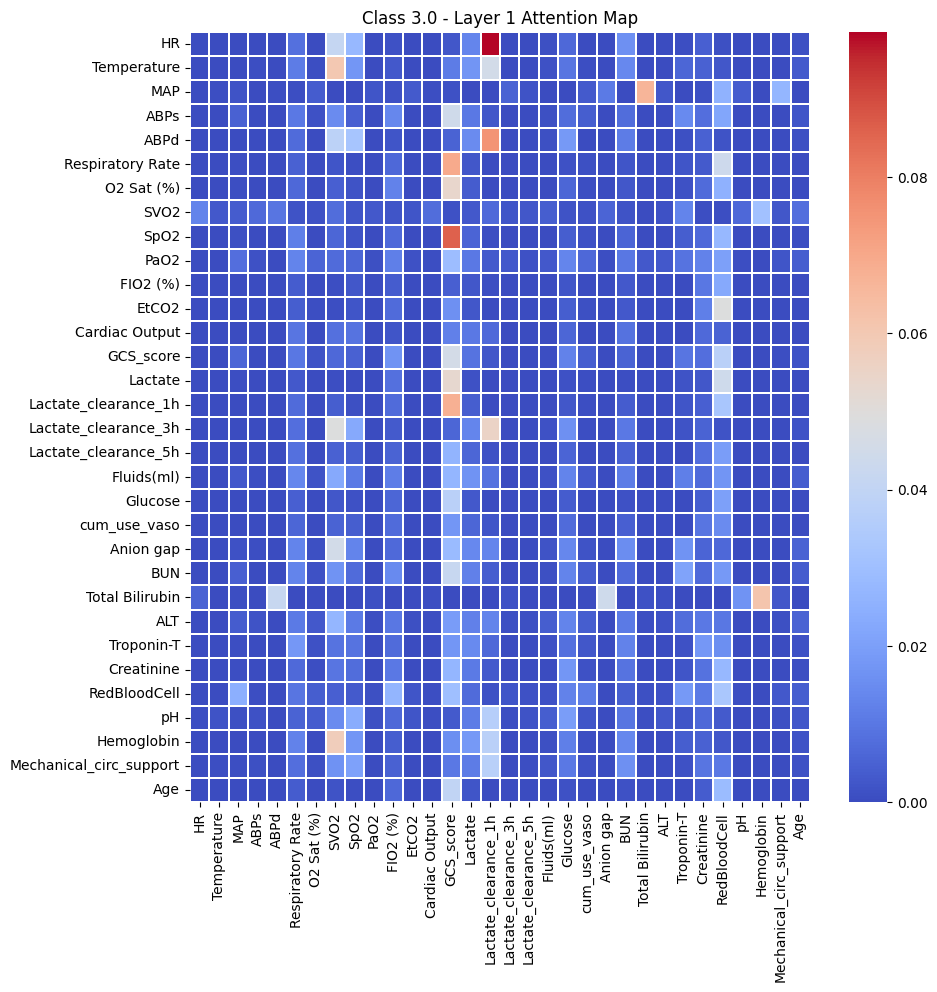

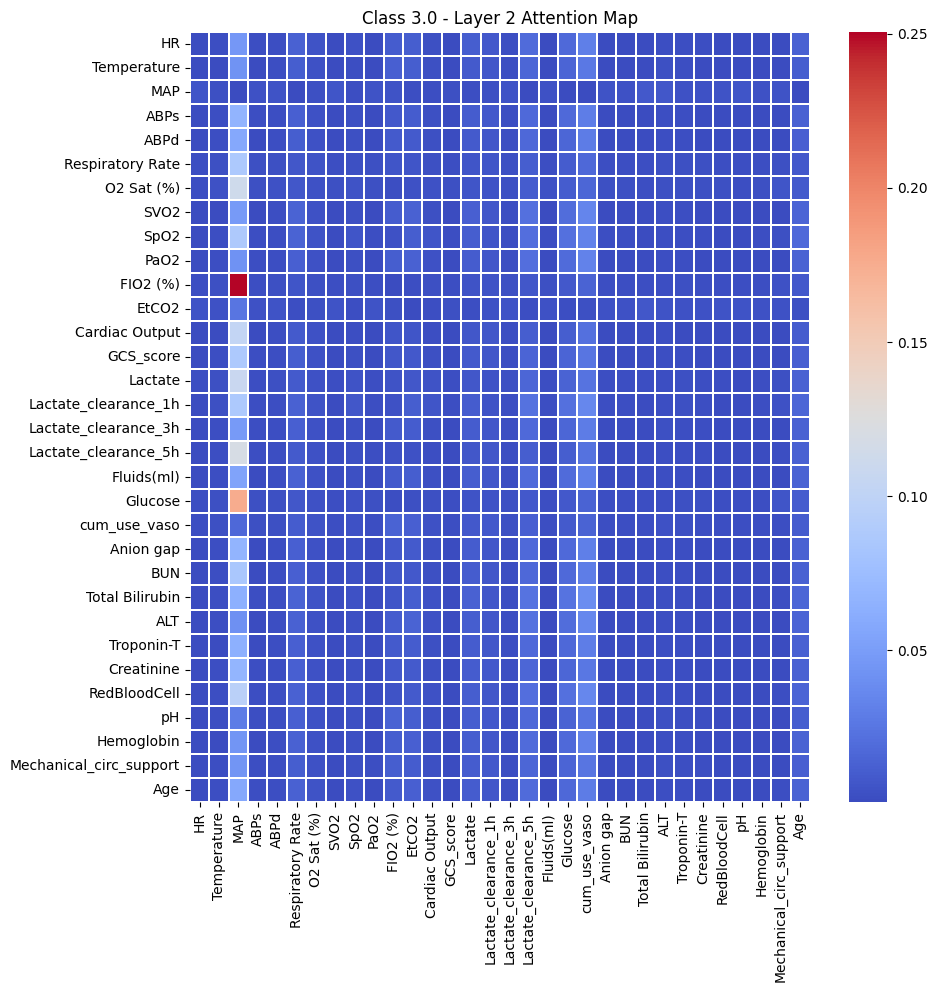

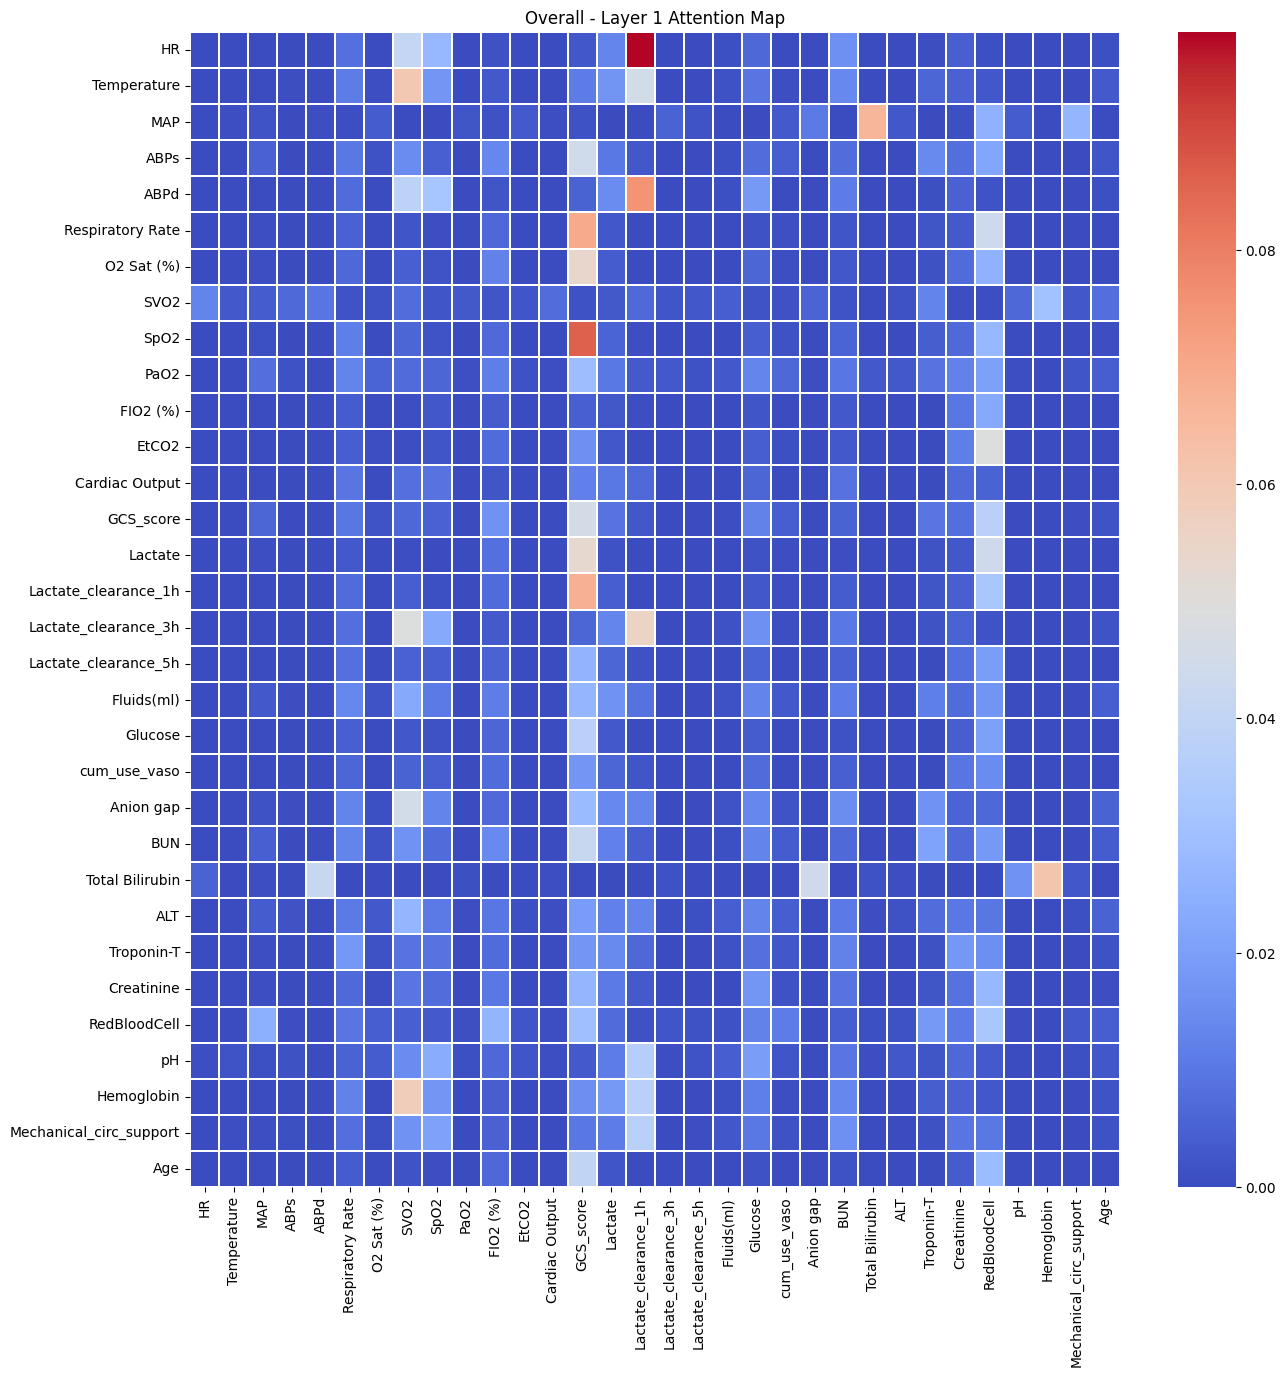

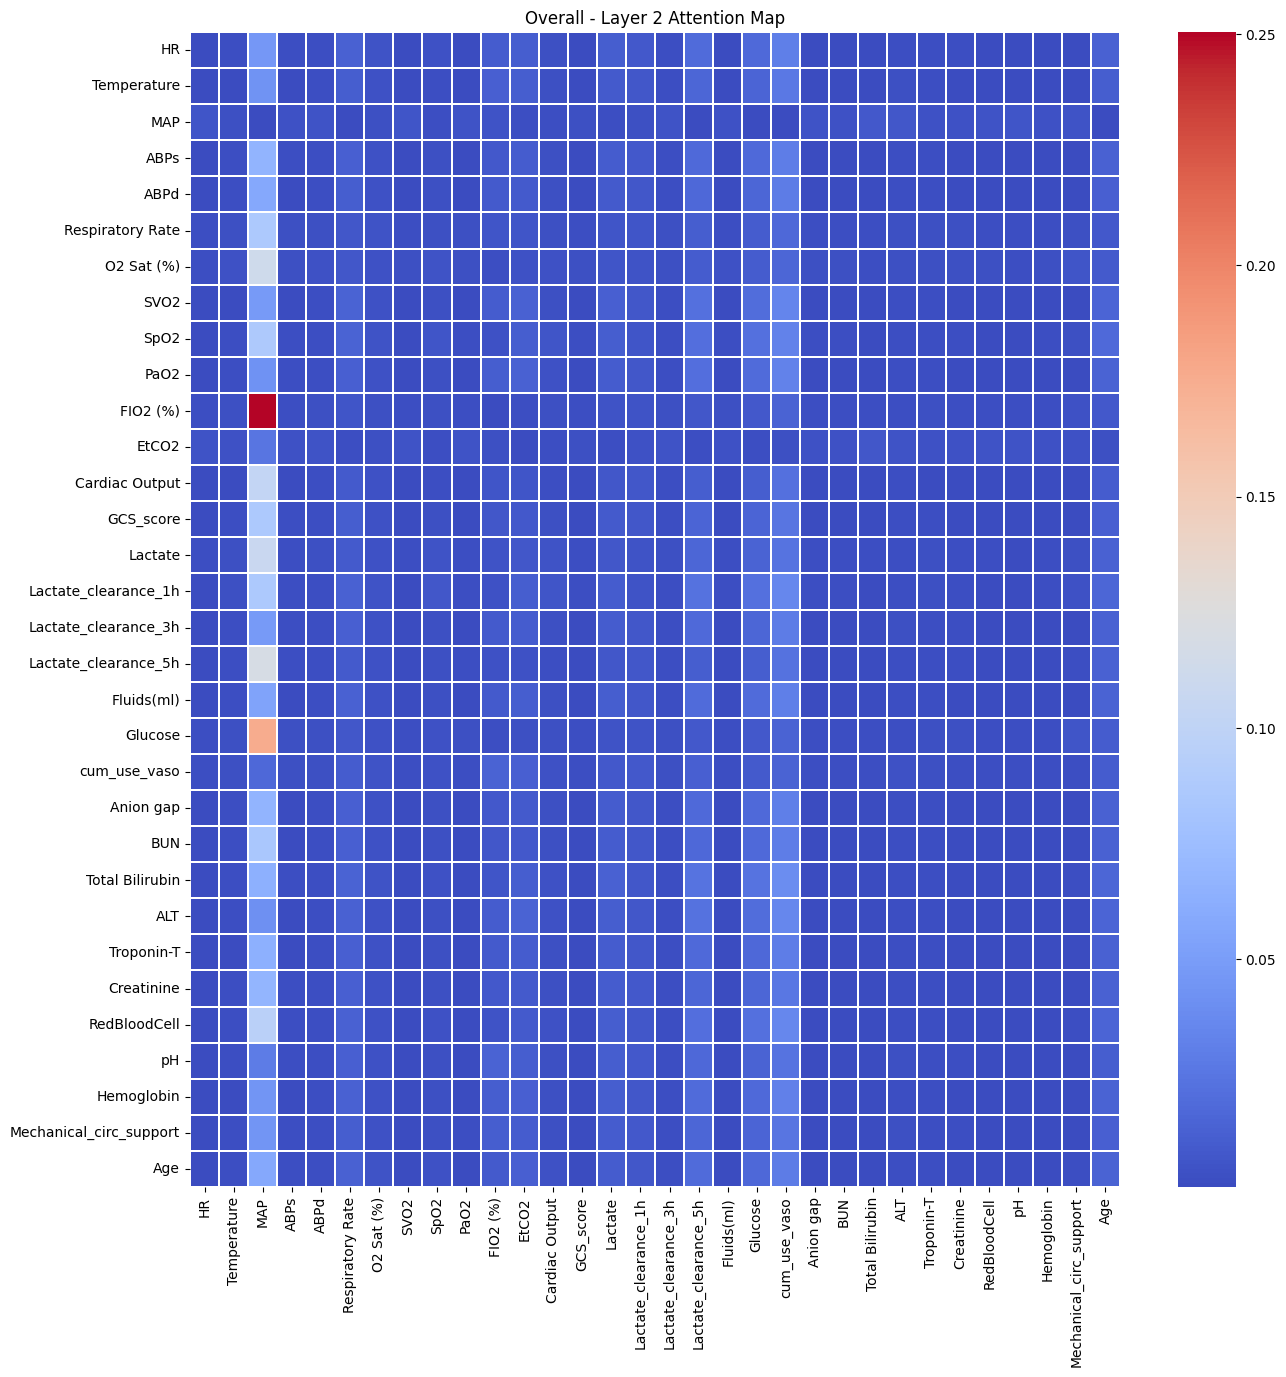

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_attention_per_class(valid_att, focus_columns, focus_columns_names):
    for class_label, class_data in valid_att.items():
        for layer in range(class_data.shape[0]):
            # 2는 head의 개수, 5000은 샘플의 수, 218x218는 attention 행렬의 크기
            # 형태: (2, 5000, 2, 218, 218)
        
            attention_head = class_data[layer, :, 0, :, :]  # 형태: (5000, 218, 218)
            
            # focus_columns 인덱스를 사용하여 정사각형 행렬을 선택
            # np.ix_ 함수는 주어진 각 배열을 행과 열의 인덱스로 변환하여 정사각형 행렬을 선택하는 데 사용
            ixgrid = np.ix_(focus_columns, focus_columns)
            attention_focus = attention_head[:, ixgrid[0], ixgrid[1]]  # 형태: (5000, focus_columns 길이, focus_columns 길이)
            
            # 샘플 차원에 대한 평균을 계산하여 평균 attention 행렬을 얻음
            attention_focus_avg = np.mean(attention_focus, axis=0)
            
            plt.figure(figsize=(10, 10))
            plt.title(f'Class {class_label} - Layer {layer+1} Attention Map')
            sns.heatmap(attention_focus_avg, cmap='coolwarm',
                        xticklabels=focus_columns_names, yticklabels=focus_columns_names, linewidths=0.1)
            plt.xticks(rotation=90)
            plt.yticks(rotation=0)
            plt.savefig(f'./result/Class_{class_label}_Layer_{layer+1}_Attention_Map.png')

def plot_attention_overall(valid_att, focus_columns, focus_columns_names):
    overall_attention = []
    for class_data in valid_att.values():
        overall_attention.append(class_data)
    overall_attention = np.concatenate(overall_attention, axis=1)

    for layer in range(overall_attention.shape[0]):
        plt.figure(figsize=(15, 15))
        plt.title(f'Overall - Layer {layer+1} Attention Map')
        attention_head = class_data[layer, :, 0, :, :]  # 형태: (5000, 218, 218)
        
        # focus_columns 인덱스를 사용하여 정사각형 행렬을 선택
        # np.ix_ 함수는 주어진 각 배열을 행과 열의 인덱스로 변환하여 정사각형 행렬을 선택하는 데 사용
        ixgrid = np.ix_(focus_columns, focus_columns)
        attention_focus = attention_head[:, ixgrid[0], ixgrid[1]]  # 형태: (5000, focus_columns 길이, focus_columns 길이)
        
        # 샘플 차원에 대한 평균을 계산하여 평균 attention 행렬을 얻음
        attention_focus_avg = np.mean(attention_focus, axis=0)
        sns.heatmap(attention_focus_avg, cmap='coolwarm',
                    xticklabels=focus_columns_names, yticklabels=focus_columns_names, linewidths=0.1)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.savefig(f'./result/Overall_Layer_{layer+1}_Attention_Map.png')

# 실행
plot_attention_per_class(valid_att, focus_columns, focus_columns_names)
plot_attention_overall(valid_att, focus_columns, focus_columns_names)


In [39]:
valid_att.shape

(2, 35584, 2, 218, 218)

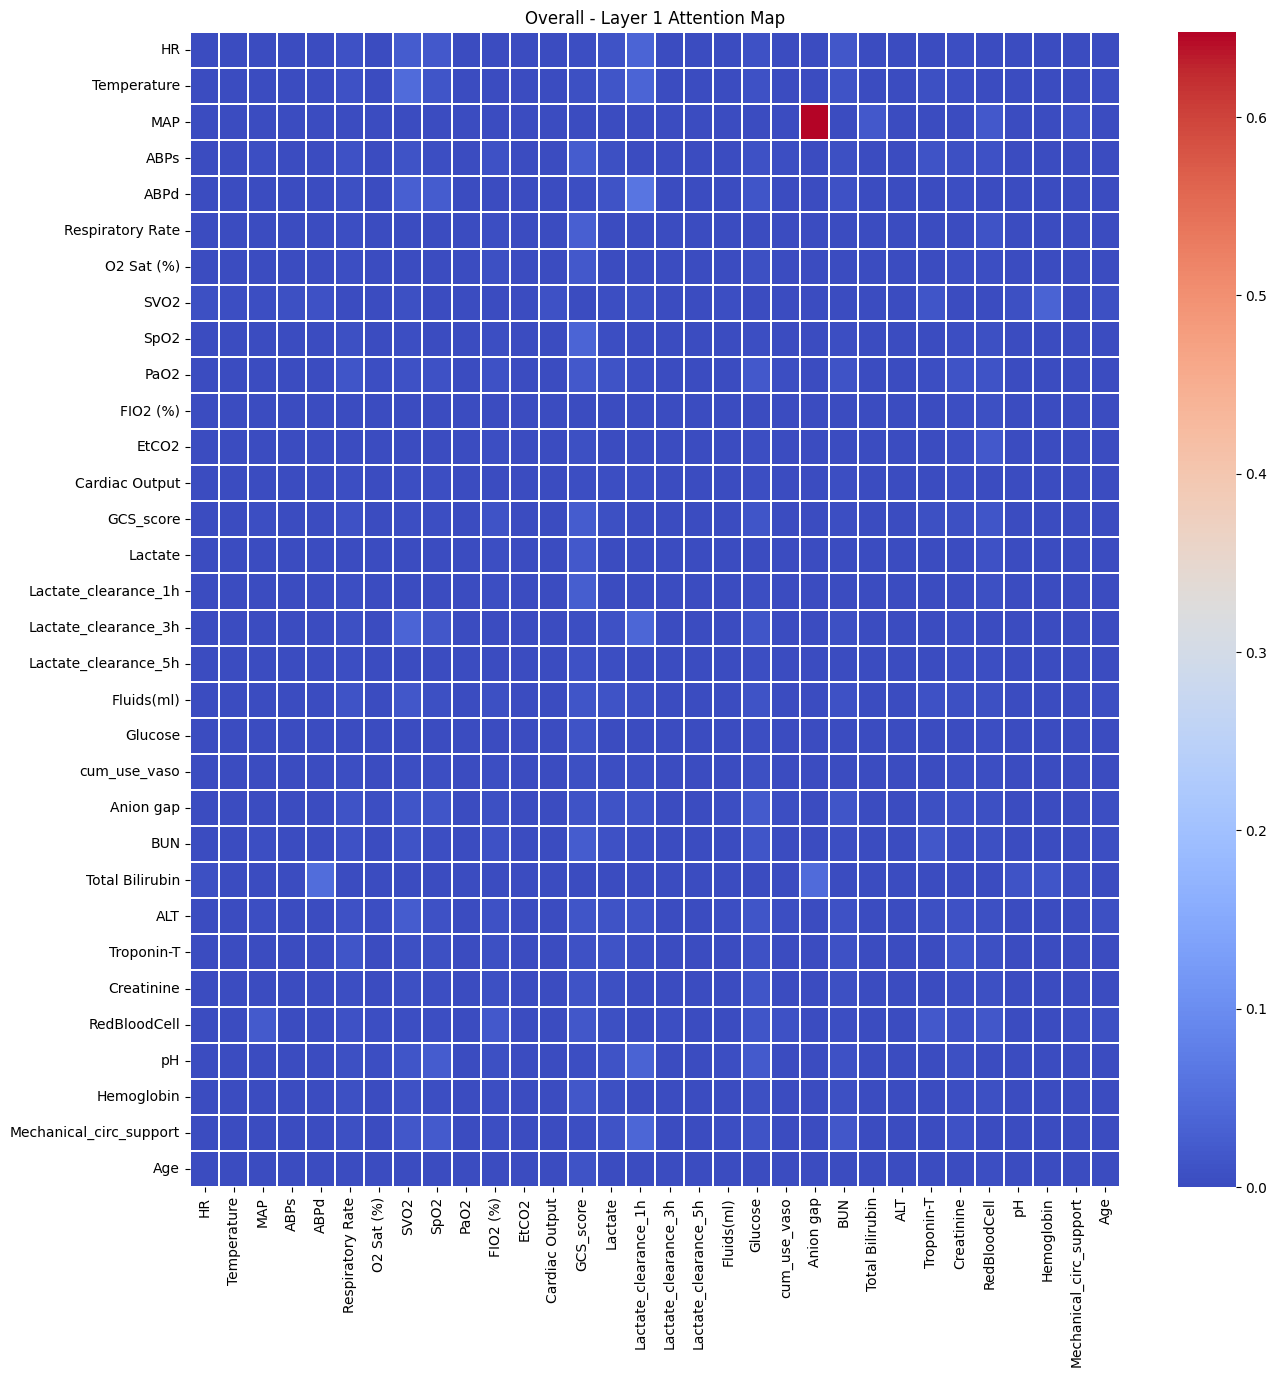

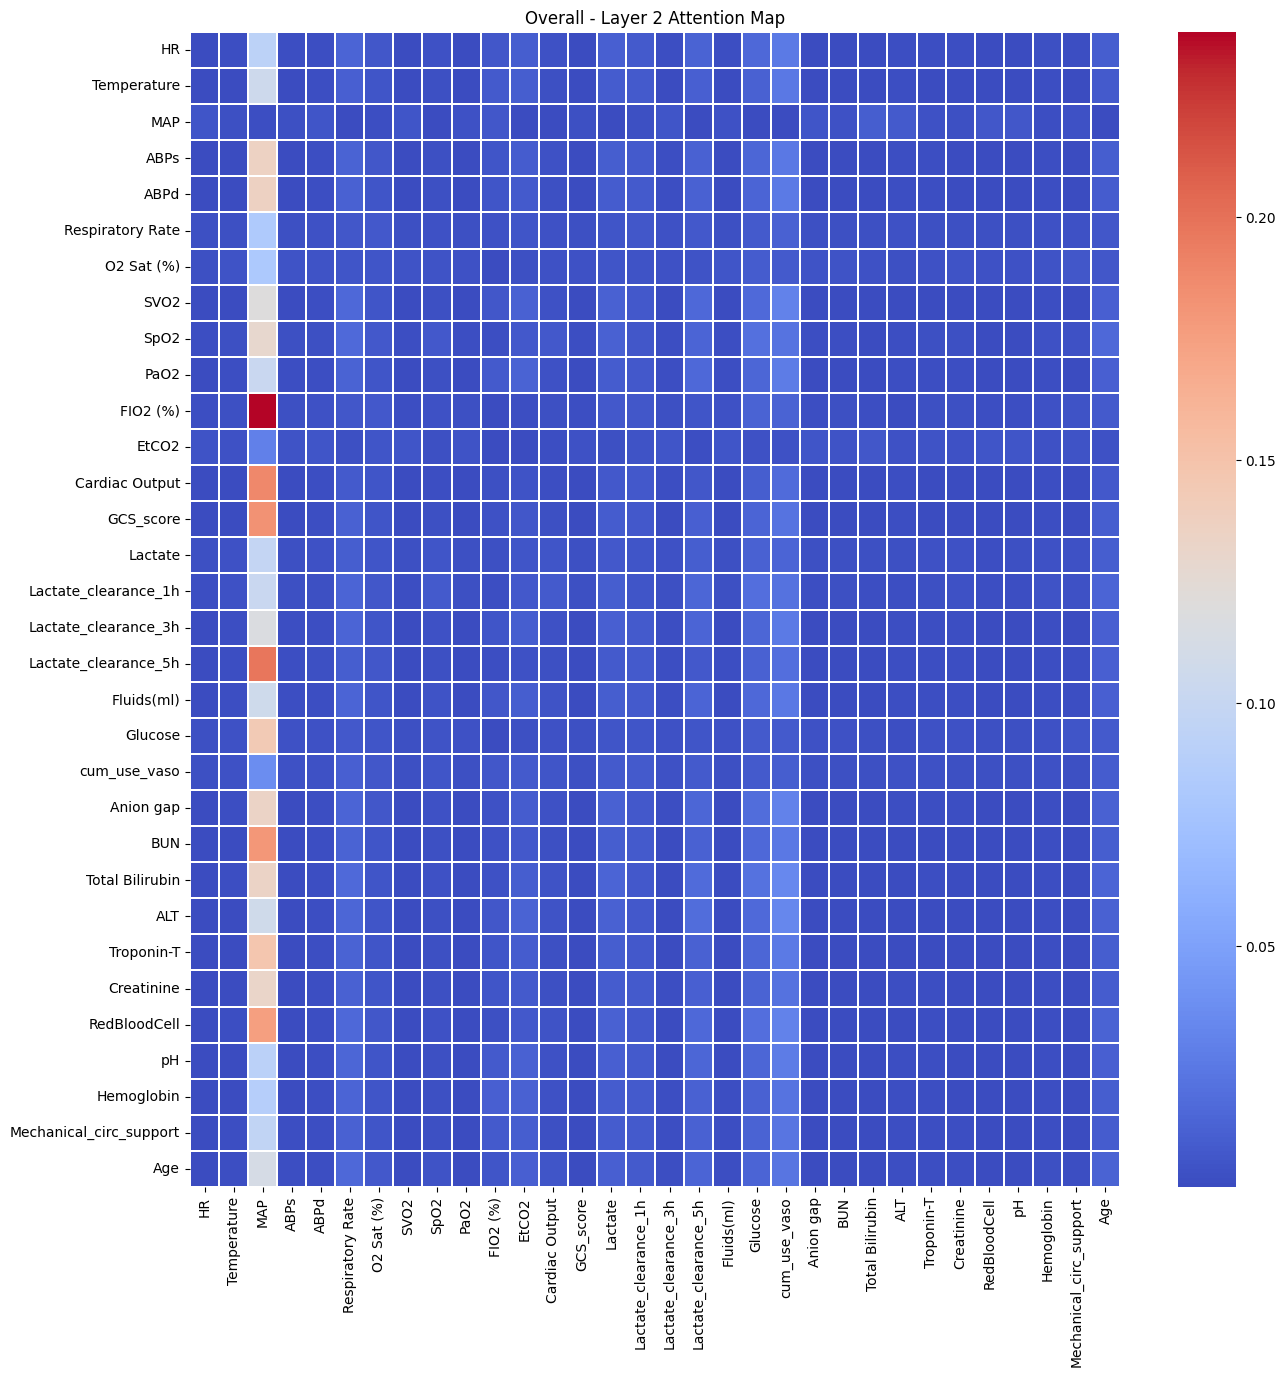

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['CLS_Token'] + dataset_vis.df_cat.columns.tolist() + dataset_vis.df_num.columns.tolist()

# focus_columns는 시각화하고자 하는 특정 컬럼들의 인덱스 리스트
focus_col_name = ['HR', 'Temperature', 'MAP', 'ABPs', 'ABPd', 'Respiratory Rate', 'O2 Sat (%)', 'SVO2', 'SpO2',
'PaO2','FIO2 (%)', 'EtCO2', 'Cardiac Output', 'GCS_score', 'Lactate', 'Lactate_clearance_1h',
'Lactate_clearance_3h', 'Lactate_clearance_5h', 'Fluids(ml)', 'Glucose', 'cum_use_vaso','Alkaline_phosphatase','Anion gap',
'BUN','Total Bilirubin', 'ALT', 'Troponin-T', 'Creatinine','RedBloodCell', 'pH', 'Hemoglobin', 'Hematocrit'
'vasoactive/inotropic', 'Mechanical_circ_support', 'Age']  # 예시로 3, 5, 7번 컬럼에 집중

focus_columns = [columns.index(col) for col in focus_col_name if col in columns]


# 필요한 컬럼 이름만 추출
focus_columns_names = [columns[i] for i in focus_columns]

for layer in range(valid_att.shape[0]):
    plt.figure(figsize=(15, 15))
    plt.title(f'Overall - Layer {layer+1} Attention Map')
    attention_head = valid_att[layer, :, 0, :, :]  # 형태: (5000, 218, 218)

    # focus_columns 인덱스를 사용하여 정사각형 행렬을 선택
    # np.ix_ 함수는 주어진 각 배열을 행과 열의 인덱스로 변환하여 정사각형 행렬을 선택하는 데 사용
    ixgrid = np.ix_(focus_columns, focus_columns)
    attention_focus = attention_head[:, ixgrid[0], ixgrid[1]]  # 형태: (5000, focus_columns 길이, focus_columns 길이)

    # 샘플 차원에 대한 평균을 계산하여 평균 attention 행렬을 얻음
    attention_focus_avg = np.mean(attention_focus, axis=0)
    sns.heatmap(attention_focus_avg, cmap='coolwarm',
                xticklabels=focus_columns_names, yticklabels=focus_columns_names, linewidths=0.1)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.savefig(f'./result/Overall_Layer_{layer+1}_Attention_Map_vis_trn.png')


# import matplotlib.pyplot as plt
# import seaborn as sns
# ## atttnmap -> (depth,b,head,seq,seq)
# # attn_map = valid_att.detach().cpu().numpy()

# for layer in range(valid_att.shape[0]):
#     # make Heatmap
#     plt.figure(figsize=(25, 25))
#     plt.title(f'Layer_{layer+1} Attention Map')
#     sns.heatmap(np.mean(np.mean(valid_att[layer,:,:,:,:],axis=1), axis = 0), cmap='coolwarm', 
#                 xticklabels= columns, yticklabels = columns, linewidths = 0.1 )
#     plt.xticks(rotation=90)
#     plt.yticks(rotation=0)
#     plt.savefig('./result' +f'/Layer_{layer+1}_Self_Attentionmap(0116).png')

In [49]:
emb_valid.iloc[:, -1].value_counts().sort_index()

0
0.0    28739
1.0     9988
2.0     2678
3.0    31905
Name: count, dtype: int64

In [16]:
emb_valid

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,0
0,7.901530,-3.175738,-9.494601,-7.291583,-4.904180,-6.365984,3.918823,-0.580686,-1.992109,-8.884280,...,2.439565,-1.782039,-5.814858,-1.100846,6.134964,-1.023997,-0.169905,-7.068107,3.045731,1.0
1,2.990846,-2.636759,-6.099977,-5.231791,-3.141899,-4.333696,1.125538,-1.276551,-1.825986,-4.961719,...,1.046102,-1.510398,-3.377519,0.433328,2.547264,-1.326340,-1.433463,-4.528010,1.363676,1.0
2,1.310721,-1.962672,-3.180736,-4.706208,-3.037618,-2.361784,0.440795,-0.872300,-1.108693,-3.500261,...,0.616206,-1.104180,-3.129340,0.442558,1.541250,-0.177350,-0.737012,-3.919735,0.225373,1.0
3,1.185465,-1.684691,-2.943748,-4.344730,-2.802137,-2.072546,0.563836,-1.093524,-0.815227,-3.316247,...,0.699133,-0.862315,-2.799839,0.256926,1.432287,0.063800,-0.302306,-3.839370,0.137340,1.0
4,1.467433,-1.575208,-3.181552,-4.303639,-2.613338,-2.004222,0.477999,-1.141325,-0.634442,-3.254402,...,0.677471,-0.792116,-2.756765,0.108620,1.486782,0.023255,0.007065,-3.831943,0.070917,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287483,-2.243902,-1.406368,-1.013510,-3.737569,0.836371,-0.257603,-2.077331,-3.058714,0.433529,-1.775093,...,-0.339360,-1.809906,-1.495440,2.576690,-2.787109,-1.613901,-0.982185,-1.643088,-2.174974,3.0
287484,-2.201683,-1.412341,-1.035031,-3.744298,0.820974,-0.281243,-2.048601,-3.057045,0.433299,-1.806997,...,-0.332714,-1.824101,-1.505202,2.568081,-2.769370,-1.607912,-0.980514,-1.659296,-2.153379,3.0
287485,-2.152931,-1.419799,-1.059833,-3.752703,0.800547,-0.308627,-2.014188,-3.048095,0.428417,-1.840459,...,-0.327255,-1.839803,-1.518079,2.557940,-2.744354,-1.602482,-0.979890,-1.677472,-2.128217,3.0
287486,-2.201322,-1.412708,-1.035699,-3.744958,0.820246,-0.282122,-2.048170,-3.056713,0.432444,-1.807724,...,-0.333014,-1.824755,-1.505876,2.568107,-2.768859,-1.608306,-0.981207,-1.660102,-2.153106,3.0


In [50]:
emb_valid.to_csv('test_umap_transforemr_vis_trn.csv')

In [46]:
emb_valid.to_csv('test_umap_transforemr.csv')

In [12]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import gc

gc.collect()

def make_embeded_df_all_case1(model_name): 
    print()
    print('Start Getting the latent space vector(Train, Valid sample)')

    start = time.time()

    model_name.eval()
    with torch.no_grad():

        att_valid_list = []
        att_valid_list_2= []
        att_valid_list_3 = []
        
        for num_iter, batch_data in enumerate(tqdm(loader_val_full_case1)):
            X_num, X_cat, _ = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)

            _, att_valid = model_name(X_cat, X_num, True)
     
            att_valid_list.append(np.mean(np.mean(att_valid[0,:,:,:,:].detach().cpu().numpy(),axis=1), axis = 0))
            att_valid_list_2.append(np.mean(np.mean(att_valid[1,:,:,:,:].detach().cpu().numpy(),axis=1), axis = 0))
            att_valid_list_3.append(np.mean(np.mean(att_valid[2,:,:,:,:].detach().cpu().numpy(),axis=1), axis = 0))
            gc.collect()

        # 리스트를 하나의 넘파이 배열로 변환
        att_valid_array = np.concatenate(att_valid_list, axis=0)
        att_valid_array_2 = np.concatenate(att_valid_list_2, axis=0)
        att_valid_array_3 = np.concatenate(att_valid_list_3, axis=0)

    # DataFrame 생성
    end = time.time()            
    print()
    print('End, Time consume(min):{}'.format((end - start)/60))  
    
    return att_valid_array, att_valid_array_2, att_valid_array_3


valid_att_case1_layer1, valid_att_case1_layer2, valid_att_case1_layer3 = make_embeded_df_all_case1(model)


Start Getting the latent space vector(Train, Valid sample)


100%|██████████| 4531/4531 [35:51<00:00,  2.11it/s]



End, Time consume(min):35.87332851489385


In [13]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import gc

gc.collect()

def make_embeded_df_all_case2(model_name): 
    print()
    print('Start Getting the latent space vector(Train, Valid sample)')

    start = time.time()

    model_name.eval()
    with torch.no_grad():

        att_valid_list = []
        att_valid_list_2= []
        att_valid_list_3 = []
        
        for num_iter, batch_data in enumerate(tqdm(loader_val_full_case2)):
            X_num, X_cat, _ = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)

            _, att_valid = model_name(X_cat, X_num, True)
         
            att_valid_list.append(np.mean(np.mean(att_valid[0,:,:,:,:].detach().cpu().numpy(),axis=1), axis = 0))
            att_valid_list_2.append(np.mean(np.mean(att_valid[1,:,:,:,:].detach().cpu().numpy(),axis=1), axis = 0))
            att_valid_list_3.append(np.mean(np.mean(att_valid[2,:,:,:,:].detach().cpu().numpy(),axis=1), axis = 0))
            gc.collect()

        # 리스트를 하나의 넘파이 배열로 변환

        att_valid_array = np.concatenate(att_valid_list, axis=0)
        att_valid_array_2 = np.concatenate(att_valid_list_2, axis=0)
        att_valid_array_3 = np.concatenate(att_valid_list_3, axis=0)

    # DataFrame 생성
    end = time.time()            
    print()
    print('End, Time consume(min):{}'.format((end - start)/60))  
    
    return att_valid_array, att_valid_array_2, att_valid_array_3


valid_att_case2_layer1, valid_att_case2_layer2, valid_att_case2_layer3 = make_embeded_df_all_case2(model)


Start Getting the latent space vector(Train, Valid sample)


100%|██████████| 247/247 [02:15<00:00,  1.83it/s]


End, Time consume(min):2.252266041437785


In [15]:
valid_att_case2_layer2.shape

(55575, 225)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
## atttnmap -> (depth,b,head,seq,seq)
attn_map = valid_att.detach().cpu().numpy()

for layer in range(attn_map.shape[0]):
    # make Heatmap
    plt.figure(figsize=(35, 35))
    plt.title(f'Layer_{layer+1} Attention Map')
    sns.heatmap(np.mean(np.mean(attn_map[layer,:,:,:,:],axis=1), axis = 0), cmap='coolwarm', 
                xticklabels= columns, yticklabels = columns, linewidths = 0.1 )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.savefig('./result' +f'/Layer_{layer+1}_Attentionmap.png')